In [1]:
from runs.run2 import run2_preprocess, run2_calculate_dissimilarity, run2_gwot
from src.extract_paths import extract_paths
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

In [3]:
folder_path = './qualia_rawdata/non_alcohol/'
qualia_color = {
    'empatic_pain': 'orange',
    'guilt': 'black',
    'fear': 'violet',
    'anger': 'red',
    'envy': 'purple',
    'sadness': 'blue',
    'surprise': 'gray',
    'joy': 'cyan',
    'amusement': 'brown',
    'romance': 'pink',
    'aesthetic_appreciation': 'yellow',
    'awe': 'green',
}
iter_num=100

In [4]:
emotions = list(qualia_color.keys())
paths = extract_paths(folder_path=folder_path)
print(f'paths{len(paths)}')
subjects, preprocessed_dfs = run2_preprocess(paths=paths)
print(f'subjects:{len(subjects)}')
print(f'preprocessed_dfs:{np.array(preprocessed_dfs).shape}')
dissimilarity_matrices, original_embeddings = run2_calculate_dissimilarity(
    preprocessed_dfs=preprocessed_dfs,
    emotions=emotions,
    plot_dim=3
)
print(f'dissimilarity_matrices:{dissimilarity_matrices.shape}')
print(f'original_embeddings: {original_embeddings.shape}')
optimal_P, optimal_Q, all_embeddings = run2_gwot(
    subjects=subjects,
    emotions=emotions,
    dissimilarity_matrices=dissimilarity_matrices,
    original_embeddings=original_embeddings,
    distance_plot_flag=False,
    iter_num=iter_num
)

paths9


subjects:9
preprocessed_dfs:(9, 66, 2)
dissimilarity_matrices:(9, 12, 12)
original_embeddings: (9, 12, 3)


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\MEIP-users\Desktop\codes\qualia_analysis\venv\Lib\site-packages\ot\bregman\_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
100%|██████████| 100/100 [16:10<00:00,  9.70s/it]


best_gw_distance: 5.369128259099705


 54%|█████▍    | 54/100 [06:48<05:47,  7.56s/it]


KeyboardInterrupt: 

In [ ]:
import os
def save_(target, file_path):
    #if not exist
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    with open(file_path, 'w') as file:
        for item in target:
            file.write("%s\n" % item)

In [ ]:
save_(target=all_embeddings, file_path='./save_datas/all_personal_mapped_embeddings.csv')

In [ ]:
class ClusterIn3D:
    def __init__(self, all_embeddings, qualia_color):
        self.all_embeddings = np.array(list(all_embeddings.values()))
        self.qualia_color = qualia_color

        self.colors = list(self.qualia_color.values())
        self.emotions = list(self.qualia_color.keys())


    def plot_unclustered_embeddings(self, fig):
        labels = ['X'] + [f'Y{i}' for i in range(1, len(self.all_embeddings))]
        markers = ['o', 'x', 's', 'd', '^', 'v', '>', '<', '*']
        handles = []
        ax = fig.add_subplot(2,2,1, projection='3d')
        for j in range(len(self.all_embeddings)):
            for i in range(self.all_embeddings.shape[1]):
                scatter = ax.scatter(self.all_embeddings[j][i, 0], self.all_embeddings[j][i, 1], color=self.colors[i], marker=markers[j], label=labels[j])
                if i==0:
                    handles.append(scatter)
        # 凡例の作成
        # handles = [plt.Line3D([0], [0], marker=markers[j], color='w', markerfacecolor='k', markersize=10, linestyle='None', label=labels[j]) for j in range(len(self.all_embeddings))]

        # グラフの装飾
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('X_embeddings and QiYi(i=1~8) embeddings')
        ax.legend(handles, labels)
        return fig
    
    def plot_all(self, n_clusters):
        fig = plt.figure(figsize=(12,9))
        fig1 = self.plot_unclustered_embeddings(fig=fig)
        fig2, cluster_emotions = self.plot_clustered_embeddings(fig=fig1, n_clusters=n_clusters)
        plt.ion()
        plt.show()
        return fig2, cluster_emotions
    
    def plot_clustered_embeddings(self, fig, n_clusters):
        # 各感情ごとにデータを収集
        emotion_embeddings = []
        for i in range(12):
            emotion_embeddings.append(np.vstack([self.all_embeddings[j][i] for j in range(len(self.all_embeddings))]))

        emotion_embeddings = np.array(emotion_embeddings)  # (12, 9, 2)の形状に変換

        # 各感情ごとにデータをフラット化
        flattened_embeddings = emotion_embeddings.reshape(12, -1)  # (12, 10)の形状に変換

        # k-meansクラスタリングの適用
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(flattened_embeddings)

        # クラスタのラベル取得
        emotion_labels = kmeans.labels_

        # クラスタごとの色設定
        cluster_colors = ['r', 'g', 'b', 'y', 'c']
        emotion_colors = [cluster_colors[label % len(cluster_colors)] for label in emotion_labels]
        handles = dict()
        #プロット
        ax = fig.add_subplot(2,2,2, projection='3d')
        handle_cluster_flags = np.zeros(n_clusters)
        # 各感情のデータポイントをクラスタごとにプロット
        for i, embedding in enumerate(emotion_embeddings):
            for j in range(len(self.all_embeddings)):
                scatter = ax.scatter(embedding[j, 0], embedding[j, 1], embedding[j, 2], color=emotion_colors[i], label=f'Cluster {emotion_labels[i]}' if j == 0 else "")
                if handle_cluster_flags[emotion_labels[i]] == 0:
                    handles[f'Cluster {emotion_labels[i]}'] = scatter
                    handle_cluster_flags[emotion_labels[i]] = 1
                ax.scatter(embedding[j, 0], embedding[j, 1], embedding[j, 2], edgecolor=emotion_colors[i], facecolor='none')

        # クラスタの凡例の追加
        # handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_colors[i], markersize=10, linestyle='None', label=f'Cluster {i}') for i in range(n_clusters)]
        # ax.legend(handles=handles, title="Clusters")

        # グラフの装飾
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('3D Scatter Embeddings with 3 Clusters')
        ax.grid(True)
        ax.legend(list(handles.values()), list(handles.keys()))

        #感情が属しているクラス分類
        cluster_emotions = {cluster: [] for cluster in range(n_clusters)}
        for i, emotion in enumerate(self.emotions):
            cluster_emotions[emotion_labels[i]].append(emotion)
        print("\nCluster Emotions:")
        for cluster, emotions in cluster_emotions.items():
            print(f"Cluster {cluster}: {emotions}")

        return fig, cluster_emotions, 


Cluster Emotions:
Cluster 0: ['empatic_pain', 'fear', 'anger', 'surprise']
Cluster 1: ['guilt', 'sadness', 'joy', 'amusement', 'romance', 'aesthetic_appreciation', 'awe']
Cluster 2: ['envy']


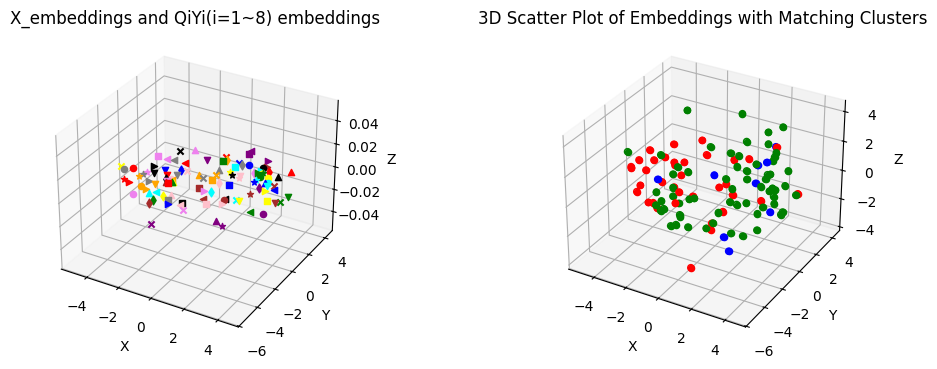

In [ ]:
cluster3d = ClusterIn3D(
    all_embeddings=all_embeddings,
    qualia_color=qualia_color
)

fig, cluster_emotions = cluster3d.plot_all(n_clusters=3)

### alcoholについてもためす

In [ ]:
folder_path = './qualia_rawdata/alcohol/'
emotions = list(qualia_color.keys())
paths = extract_paths(folder_path=folder_path)
print(f'paths{len(paths)}')
subjects, preprocessed_dfs = run2_preprocess(paths=paths)
print(f'subjects:{len(subjects)}')
print(f'preprocessed_dfs:{np.array(preprocessed_dfs).shape}')
dissimilarity_matrices, original_embeddings = run2_calculate_dissimilarity(
    preprocessed_dfs=preprocessed_dfs,
    emotions=emotions,
    plot_dim=3
)
print(f'dissimilarity_matrices:{dissimilarity_matrices.shape}')
print(f'original_embeddings: {original_embeddings.shape}')
optimal_P, optimal_Q, all_embeddings2 = run2_gwot(
    subjects=subjects,
    emotions=emotions,
    dissimilarity_matrices=dissimilarity_matrices,
    original_embeddings=original_embeddings,
    distance_plot_flag=False,
    iter_num=iter_num
)

save_(target=all_embeddings2, file_path='./save_datas/all_personal_mapped_al_embeddings.csv')

cluster3d = ClusterIn3D(
    all_embeddings=all_embeddings2,
    qualia_color=qualia_color
)

fig, cluster_emotions = cluster3d.plot_all(n_clusters=3)